# Multi-Modal Search on the Amazon Products Dataset


## Introduction

The [_Amazon Products Dataset_](http://jmcauley.ucsd.edu/data/amazon/links.html) contains product metadata, reviews, and image vectors for 9.4 million Amazon products. The dataset was collected by researchers at UCSB. The image vectors were computed using a convolutional neural network. For more information, see the paper _Justifying recommendations using distantly-labeled reviews and fined-grained aspects_ by Jianmo Ni, Jiacheng Li, and Julian McAuley. 

In this tutorial, we'll use the metadata and image vectors from the _clothing, shoes, and jewelry_ category to demonstrate how Elastiknn can be used for multi-modal search. 

Specifically, we'll search for products using text keywords, search for similar-looking products using nearest neighbor queries on the image vectors, and then combine the keyword and nearest-neighbor searches. 

We'll use and compare the nearest neighbor search functionality that's built into Elasticsearch against functionality that's available in the Elastiknn plugin.

The tutorial assumes you are comfortable with Python and the Elasticsearch JSON API. To modify and run it on your own, you'll need to [install Elastiknn](https://elastiknn.com/installation/).

## Download the Data

Download two files:

1. meta_Home_and_Kitchen.json.gz - contains the product metadata.
2. image_features_Home_and_Kitchen.b - contains pre-computed image vectors.

In [1]:
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Clothing_Shoes_and_Jewelry.json.gz
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/image_features/categoryFiles/image_features_Clothing_Shoes_and_Jewelry.b

!du -hs meta_Clothing_Shoes_and_Jewelry.json.gz
!du -hs image_features_Clothing_Shoes_and_Jewelry.b

File ‘meta_Clothing_Shoes_and_Jewelry.json.gz’ already there; not retrieving.

File ‘image_features_Clothing_Shoes_and_Jewelry.b’ already there; not retrieving.

268M	meta_Clothing_Shoes_and_Jewelry.json.gz
23G	image_features_Clothing_Shoes_and_Jewelry.b


## Explore the Data

Let's have a look at the data. 

The `amazonutils` module includes functions for iterating over the data. Let's first import that and some others.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from amazonutils import *
from itertools import islice
from tqdm import tqdm
from pprint import pprint
from IPython.display import Image, display, Markdown
import matplotlib.pyplot as plt
import numpy as np

fname_products = "meta_Clothing_Shoes_and_Jewelry.json.gz"
fname_vectors = "image_features_Clothing_Shoes_and_Jewelry.b"

Let's iterate over the metadata for a few products. Notice each product's metadata is a dictionary containing a title, description, image url, etc. We'll display the images using the URL.

{'asin': '0456830197',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Women',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Men',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/21PGEX1t2pL.jpg',
 'salesRank': {'Shoes': 257607},
 'title': "NVC Unisex Light Weight Silver 'Dakota' Glasses Case with Brushed "
          'Metal Finish'}


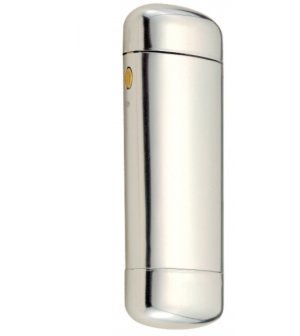

{'asin': '0456856293',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Women',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Men',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/31-NheYDxSL._SX395_.jpg',
 'salesRank': {'Shoes': 399415},
 'title': 'Kismeth Eyewear Classic Large Top Gun Aviator Sunglasses with Gold '
          'Frames &amp; Green Smoked Lenses'}


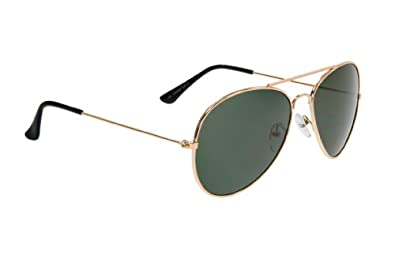

{'asin': '0456840532',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Women',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Men',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Novelty, Costumes & More',
                 'Band & Music Fan',
                 'Accessories']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/11q4qGCdw3L.jpg',
 'salesRank': {'Clothing': 2728771},
 'title': 'Max-MPH Black - Large Wayfarer Sunglasses Available in Black with '
          'Extra Dark Lenses &amp; Black with Clear (No Strength) Lenses'}


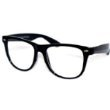

{'asin': '0456787283',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Women',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Men',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Novelty, Costumes & More',
                 'Band & Music Fan',
                 'Accessories']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/31dS6eGuUvL._SX342_.jpg',
 'salesRank': {'Clothing': 456854},
 'title': 'FX1 Small Adult Aviator Sunglasses with Silver Frames &amp; Fully '
          'Mirrored Lenses Offering Full UV400 Protection Cat 4 Lenses'}


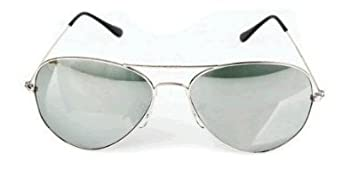

{'asin': '0456838384',
 'categories': [['Clothing, Shoes & Jewelry',
                 'Women',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Men',
                 'Accessories',
                 'Sunglasses & Eyewear Accessories',
                 'Sunglasses'],
                ['Clothing, Shoes & Jewelry',
                 'Novelty, Costumes & More',
                 'Band & Music Fan',
                 'Accessories']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/31b1J21ildL._SX342_.jpg',
 'salesRank': {'Clothing': 437391},
 'title': 'Riz Small Unisex (Mens/ Womens) Black Classic Wayfarer Sunglasses '
          "with Gradient Smoked Lenses - NEW 'Cool Blue Technology' Lenses"}


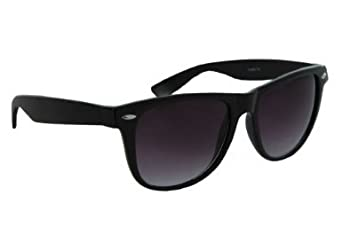

In [3]:
for p in islice(iter_products(fname_products), 5, 10):
    pprint({k:v for (k,v) in p.items() if k not in {'related', 'description'}})
    display(Image(p['imUrl'], width=128, height=128))

Let's use the `iter_vectors` function to iterate over product IDs and image vectors. Each vector is just a list of 4096 floats, generated using a deep convolutional neural network. There is little value in inspecting the individual vectors, so we'll just show the vector length and first few values for each one. 

In [4]:
for (asin, vec) in islice(iter_vectors(fname_vectors), 3):
    print(asin, len(vec), vec[:5])

B000IG9NS6 4096 [0.0, 0.608299970626831, 0.0, 0.0, 0.0]
B000FIPV42 4096 [0.0, 0.0, 0.0, 0.0, 0.0]
B000FZ1AO0 4096 [0.4043000042438507, 0.0, 4.453100204467773, 0.0, 0.0]


Let's sample a subset of vectors and plot the distribution of values. This will be more informative than inspecting individual vectors.

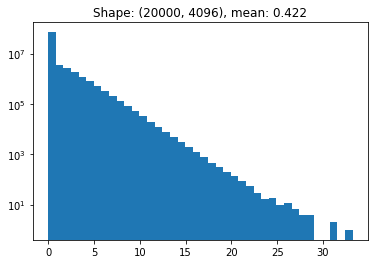

In [5]:
sample = np.array([v for (_, v) in islice(iter_vectors(fname_vectors), 20000)])
plt.title("Shape: %s, mean: %.3f" % (sample.shape, sample.mean()))
plt.hist(np.ravel(sample), bins=40, log=True)
plt.show()

The histogram above shows there are many zeros in the vectors. 

The zeros usually don't add much information when computing vector similarities. (Forgive my mathematical hand-waviness.) At the same time, the zeros occupy storage space, memory, and CPU. We should be able to reduce the dimensionality while preserving most of the information.

I included a simple dimensionality reduction technique in the function `iter_vectors_reduced`. It takes the file name, the desired `dims`, and a number of `samples`. It iterates over the first `samples` vectors in the given file name, maintaining a sum along each index. It then computes the `dims` indices with the largest sums. It returns anoter generator function which will iterate over the vectors in a given file name and return only the greatest indices based on the original sample.

Let's reduce the dimensionality from 4096 to 128 and inspect the results.

B000IG9NS6 128 [5.9893999099731445, 0.0, 3.8183999061584473, 2.5580999851226807, 1.5513999462127686]
B000FIPV42 128 [4.293399810791016, 0.0, 3.595599889755249, 0.0, 0.0]
B000FZ1AO0 128 [2.1886000633239746, 1.9733999967575073, 12.249600410461426, 4.564300060272217, 7.321000099182129]


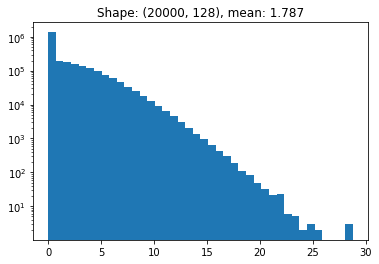

In [6]:
reduced = iter_vectors_reduced(fname_vectors, dims=128, samples=10000)

for (asin, vec) in islice(reduced(fname_vectors), 3):
    print(asin, len(vec), vec[:5])

sample = np.array([v for (_, v) in islice(reduced(fname_vectors), 20000)])
plt.title("Shape: %s, mean: %.3f" % (sample.shape, sample.mean()))
plt.hist(np.ravel(sample), bins=40, log=True)
plt.show()

Now we have more than an order of magnitude fewer zeros and only need to store and compute for 128 dimensions instead of 4096.

## Connect to Elasticsearch

In [46]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk

es = Elasticsearch(["http://localhost:9200"])
es.cluster.health(wait_for_status='yellow', request_timeout=1)

{'cluster_name': 'docker-cluster',
 'status': 'green',
 'timed_out': False,
 'number_of_nodes': 1,
 'number_of_data_nodes': 1,
 'active_primary_shards': 1,
 'active_shards': 1,
 'relocating_shards': 0,
 'initializing_shards': 0,
 'unassigned_shards': 0,
 'delayed_unassigned_shards': 0,
 'number_of_pending_tasks': 0,
 'number_of_in_flight_fetch': 0,
 'task_max_waiting_in_queue_millis': 0,
 'active_shards_percent_as_number': 100.0}

## Create the Elasticsearch Index

Now we understand the shape of our dataset: each product has a dictionary of metadata and an 128-dimensional image vector.

Let's create an index and define a mapping that represents the shape of our data.
The mapping has the following properties:

|property|type|description|
|:--|:--|:--|
|asin|keyword|Unique product identifier.|
|imVecElastiknn|elastiknn_dense_float_vector|The image vector, stored using Elastiknn. We'll also use the Angular LSH model to support approximate nearest neighbor queries.|
|imVecXpack|dense_vector|The image vector, stored using the X-Pack dense_vector data type.|
|title|text||
|description|text||
|price|float||

We're including two vectors: one using the `dense_vector` datatype that comes with Elasticsearch, the other using the `elastiknn_dense_float_vector` datatype provided by Elastiknn. We're including both so we can compare functionality and performance. 

I've chosen to use Angular similarity for finding similar vectors (i.e. similarly-looking products). I made this choice by experimenting with L2 and Angular similarity and seeing qualitatively better results with Angular similarity. The similarity function that works best for your vectors has a lot to do with how the vectors were computed. In this case, I don't know a lot about how the vectors were computed, so a bit of guess-and-check was required.

In [42]:
index = 'amazon-products'

if es.indices.exists(index):
    es.indices.delete(index)

es.indices.create(index, {
    "settings": {
        "elastiknn": True,
        "number_of_shards": 1,
        "number_of_replicas": 0
    }
})

mapping = {
    "properties": {
        "asin": { "type": "keyword" },
        "imVecElastiknn": {
            "type": "elastiknn_dense_float_vector",
            "elastiknn": {
                "dims": 128,
                "model": "lsh",
                "similarity": "angular",
                "L": 60,
                "k": 3
            }
        },
        "imVecXpack": {
            "type": "dense_vector",
            "dims": 128
        },
        "title": { "type": "text" },
        "description": { "type": "text" },
        "price": { "type": "float" },
        "imUrl": { "type": "text" }
    }
}
es.indices.put_mapping(mapping, index)

es.indices.get_mapping(index)

{'amazon-products': {'mappings': {'properties': {'asin': {'type': 'keyword'},
    'description': {'type': 'text'},
    'imUrl': {'type': 'text'},
    'imVecElastiknn': {'type': 'elastiknn_dense_float_vector',
     'elastiknn': {'model': 'lsh',
      'similarity': 'angular',
      'dims': 128,
      'L': 60,
      'k': 3}},
    'imVecXpack': {'type': 'dense_vector', 'dims': 128},
    'price': {'type': 'float'},
    'title': {'type': 'text'}}}}}

## Index the Products

Now that we've created a new index with an appropriate mapping, we'll index (i.e., store) the data.

We'll first iterate over the product data, using the `asin` as the document ID and storing everything except the vectors. We'll iterate over the vectors separately to store them.

There are about 1.5M products, and the indexing takes about 5 minutes on my laptop.

In [43]:
def product_actions():
    for p in tqdm(iter_products(fname_products)):
        yield { 
            "_op_type": "index", "_index": index, "_id": p["asin"], 
            "asin": p["asin"], "title": p.get("title", None), 
            "description": p.get("description", None),
            "price": p.get("price", None),
            "imUrl": p.get("imUrl", None)
        }

bulk(es, product_actions(), chunk_size=1000, max_retries=2)

1503384it [03:50, 6514.43it/s]


(1503384, [])

Indexing the vectors is slower, about 25 minutes for 1.5M vectors. Note that not all of the docs will have vectors.

In [44]:
reduced = iter_vectors_reduced(fname_vectors, 128, 10000)

def vector_actions():
    for (asin, v) in tqdm(reduced(fname_vectors)):
        yield { "_op_type": "update", "_index": index, "_id": asin, 
                "doc": { "imVecElastiknn": { "values": v }, "imVecXpack": v }}

bulk(es, vector_actions(), chunk_size=250, max_retries=2)

1494171it [23:27, 1061.66it/s]


(1494171, [])

Refresh the index and merge it into 1 shard. This should ensure you get consistent query results below.

In [59]:
es.indices.refresh(index=index)
es.indices.forcemerge(index=index, max_num_segments=1, request_timeout=120)

{'_shards': {'total': 1, 'successful': 1, 'failed': 0}}

In [71]:
# List of dccument fields needed for displaying (i.e. everything minus the vectors).
source_no_vecs = ['asin', 'title', 'description', 'price', 'imUrl']

## Start searching with a keyword query

Imagine you're shopping for a men's wrist watch on Amazon.

You'll start by matching a simple keyword query: _**timex men's watch**_

This is a pretty broad term, so the results that show up if you re-run this notebook might be different.

Found 10000 hits in 5 ms

Title:          Timex Men's T71532 Watch
Description:    None...
Price:          None
ID:             B0009Y6F38
Score:          29.368631


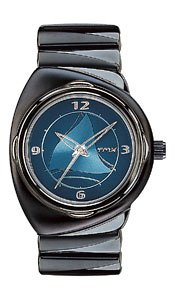


Title:          Timex Men's T42631 Watch
Description:    None...
Price:          None
ID:             B000AYTYPI
Score:          29.368631


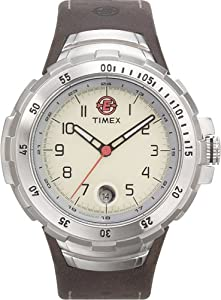


Title:          Timex Men's T41481 Watch
Description:    None...
Price:          None
ID:             B0009352M4
Score:          29.368631


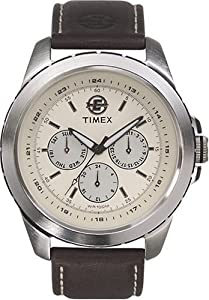


Title:          Timex Men's Watch T41381
Description:    None...
Price:          None
ID:             B0009AFL0A
Score:          29.368631


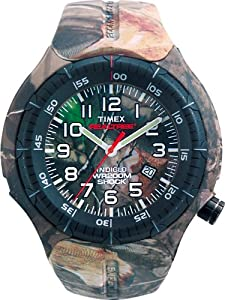


Title:          Timex Men's T28342 Watch
Description:    None...
Price:          None
ID:             B000AYSGRU
Score:          29.368631


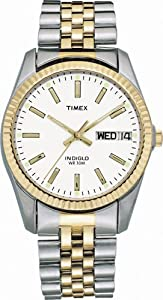

In [73]:
body = {
    "query": {
        "multi_match": {
            "query": "timex men's watch",
            "fields": ["title^2", "description"]
        }
    }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

## Find similar-looking products using stock Elasticsearch

You really like the "Timex Men's T71542 Watch" (ID `B0009Y6F38`) and want to explore some similar-looking options.

We'll start by using stock Elasticsearch functionality to do an exhaustive nearest neighbors query. This compares a given vector against all of the image vectors in the index.

This query consists of three steps:

1. Fetch the image vector for your favorite product.
2. Use the vector to build a script-score query to compute the `cosineSimilarity` between the image vector and all ~1.5M other vectors in the index.
3. Execute the query. 

Found 10000 hits in 380 ms

Title:          Timex Men's T71532 Watch
Description:    None...
Price:          None
ID:             B0009Y6F38
Score:          2.0


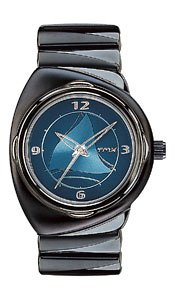


Title:          Fossil Women's Watch BG1067
Description:    None...
Price:          None
ID:             B000B5K89M
Score:          1.8956606


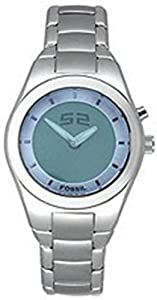


Title:          Fossil Women's Blue Teq watch #AM3719
Description:    None...
Price:          None
ID:             B0000Z7KNK
Score:          1.8917472


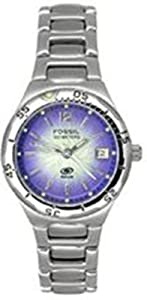


Title:          Freestyle Men's FS75330 Sand Tiger Polyurethane Watch
Description:    None...
Price:          None
ID:             B000GHG9A2
Score:          1.8883127


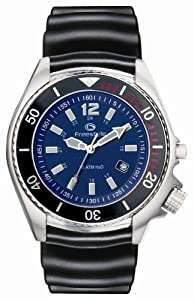


Title:          Casio Men's VQ201HDA-2AV Waveceptor Atomic Watch
Description:    None...
Price:          None
ID:             B000AQTAGO
Score:          1.8856603


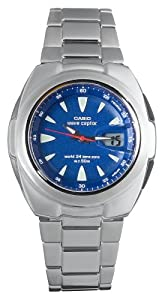

In [75]:
product_id = "B0009Y6F38"

fetch_res = es.get(index=index, id=product_id)
query_vec = fetch_res['_source']['imVecXpack']

body = {
    "query": {
        "script_score": {
            "query": { "match_all": {} },
            "script": {
                # If the `imVecXpack` vector is missing, just return 0. Else compute the similarity.
                "source": 'doc["imVecXpack"].size() == 0 ? 0 : 1.0 + cosineSimilarity(params.vec, "imVecXpack")',
                "params": {
                    "vec": query_vec
                }
            }
        }
    }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

## Find similar-looking products using Elastiknn's exact nearest neighbors query

Let's implement the same nearest_neighbors query using Elastiknn. You'll notice two differences compared to the previous query:

1. We reference the query vector using its document ID and the field containing the vector. This avoids a round trip request to fetch the vector.
2. We don't need to use a script. The whole query is simple JSON keys and values.

Note the results are identical to the stock Elasticsearch query.

Found 10000 hits in 446 ms

Title:          Timex Men's T71532 Watch
Description:    None...
Price:          None
ID:             B0009Y6F38
Score:          2.0


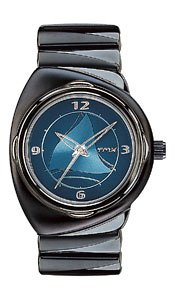


Title:          Fossil Women's Watch BG1067
Description:    None...
Price:          None
ID:             B000B5K89M
Score:          1.8956606


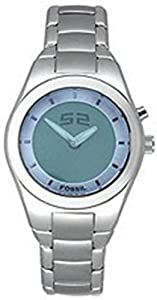


Title:          Fossil Women's Blue Teq watch #AM3719
Description:    None...
Price:          None
ID:             B0000Z7KNK
Score:          1.8917471


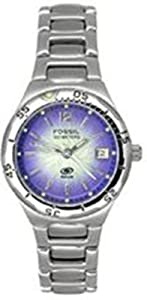


Title:          Freestyle Men's FS75330 Sand Tiger Polyurethane Watch
Description:    None...
Price:          None
ID:             B000GHG9A2
Score:          1.8883127


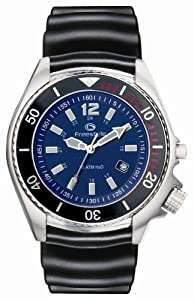


Title:          Casio Men's VQ201HDA-2AV Waveceptor Atomic Watch
Description:    None...
Price:          None
ID:             B000AQTAGO
Score:          1.8856603


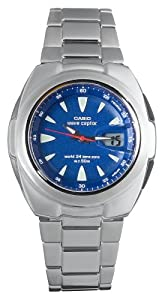

In [76]:
body = {
    "query": {
        "elastiknn_nearest_neighbors": {
            "vec": {
                "index": index,
                "id": product_id,
                "field": "imVecElastiknn"
            },
            "field": "imVecElastiknn",
            "model": "exact",
            "similarity": "angular"
        }
    }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

## Find similar-looking products (faster) using Elastiknn's approximate query

Both of the previous queries take > 300ms to return. Each query scores _every_ vector in the index, so this only increases as the index grows.

To address this, Elastiknn offers approximate nearest neighbors queries based on the [Locality Sensitive Hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing) technique. 

We used the angular LSH model (i.e. `"model": "lsh", "similarity": "angular"`) when defining the mapping (right before indexing the data). So we can use the same model and similarity to run an approximate nearest neighbors query. This query takes a `"candidates"` parameter, which is the number of approximate matches that will be re-ranked using the exact similarity score.

Using the approximate query with 50 candidates yields reasonable results in around 200 ms. You can tweak the mapping and query parameters to fine-tune the latency/quality tradeoff. The [API documentation](https://elastiknn.com/api/) includes notes on how the parameters affect latency/quality.

Found 50 hits in 226 ms

Title:          Timex Men's T71532 Watch
Description:    None...
Price:          None
ID:             B0009Y6F38
Score:          2.0


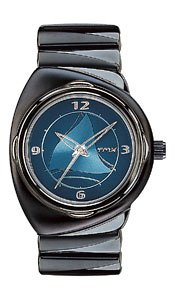


Title:          Fossil Women's Blue Teq watch #AM3719
Description:    None...
Price:          None
ID:             B0000Z7KNK
Score:          1.8917471


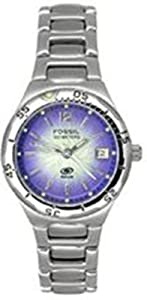


Title:          Freestyle Men's FS75330 Sand Tiger Polyurethane Watch
Description:    None...
Price:          None
ID:             B000GHG9A2
Score:          1.8883127


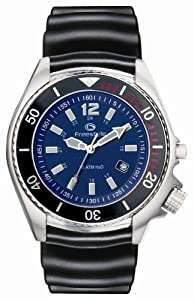


Title:          Mens Croton Steel Automatic Date Watch CA301150SSRD
Description:    None...
Price:          None
ID:             B001S1QK4K
Score:          1.8822705


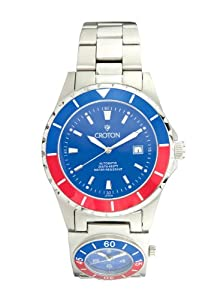


Title:          Invicta 7318 Men's Signature II Collection Stainless Steel Watch
Description:    None...
Price:          None
ID:             B004YLTDI6
Score:          1.8818339


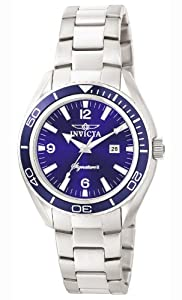

In [77]:
body = {
    "query": {
        "elastiknn_nearest_neighbors": {
            "vec": {
                "index": index,
                "field": "imVecElastiknn",
                "id": product_id
            },
            "field": "imVecElastiknn",
            "model": "lsh",
            "similarity": "angular",
            "candidates": 50
        }
    }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

## Combine keyword and nearest neighbors queries using stock Elasticsearch

The previous queries returned some nice results, but you decide you really want this watch to be black.

To support this, we can combine a keyword query for "Black" with a nearest neighbors query. 

Stock Elasticsearch lets us do this by modifying the `query` clause in the `script_score` query.

Found 10000 hits in 79 ms. Showing top 5.

Title:          Swatch Men's YTS403G Quartz Black Dial Date Stainless Steel Watch
Description:    None...
Price:          129.32
ID:             B005IWAY9C
Score:          1.846451


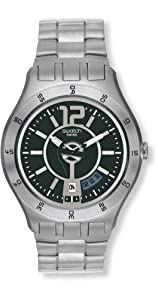


Title:          Sprout Women's ST4008JMBK  Black Corn Resin Bracelet Watch
Description:    None...
Price:          None
ID:             B0044X5JAU
Score:          1.8382981


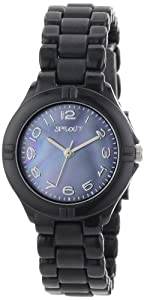


Title:          Citizen Men's AT0940-50E Eco-Drive Titanium Chronograph Black Dial Watch
Description:    None...
Price:          281.25
ID:             B0032FOSFI
Score:          1.8312382


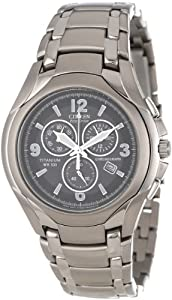


Title:          Men's Black Stainless Steel Quartz Chronograph Date Display Roman Numerals
Description:    None...
Price:          228.99
ID:             B005OB6UPY
Score:          1.826895


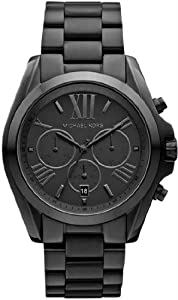


Title:          Peugeot Women's PS4905BS Swiss Ceramic Black Crystal Bezel Watch
Description:    None...
Price:          175.0
ID:             B00753QOAA
Score:          1.8248829


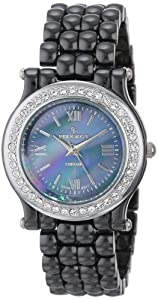

In [94]:
body = {
    "query": {
        "script_score": {
            "query": {
                "multi_match": {
                    "query": "Black",
                    "fields": ["title^2", "description"]
                }
            },
            "script": {
                "source": 'doc["imVecXpack"].size() == 0 ? 0 : 1.0 + cosineSimilarity(params.vec, "imVecXpack")',
                "params": {
                    "vec": query_vec
                }
            }
        }
    }
}
res = es.search(index=index, body=body, size=5)
display_hits(res)

## Combine keyword and nearest neighbors queries using Elastiknn exact query

We can do the same thing using a function score query containing an `elastiknn_nearest_neighbors` function. This function takes the exact same parameters as an `elastiknn_nearest_neighbors` query.

Note that the function score query gives you quite a bit more flexibility. Specifically, you can tweak the `boost_mode` parameter to control how the keyword and nearest neighbor queries are combined and tweak the `weight` to scale the nearest neighbor query score.

Found 10000 hits in 94 ms. Showing top 5.

Title:          Swatch Men's YTS403G Quartz Black Dial Date Stainless Steel Watch
Description:    None...
Price:          129.32
ID:             B005IWAY9C
Score:          5.5393534


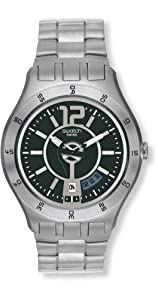


Title:          Sprout Women's ST4008JMBK  Black Corn Resin Bracelet Watch
Description:    None...
Price:          None
ID:             B0044X5JAU
Score:          5.5148945


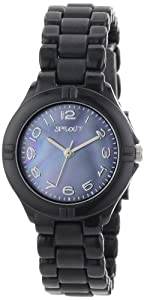


Title:          Citizen Men's AT0940-50E Eco-Drive Titanium Chronograph Black Dial Watch
Description:    None...
Price:          281.25
ID:             B0032FOSFI
Score:          5.4937143


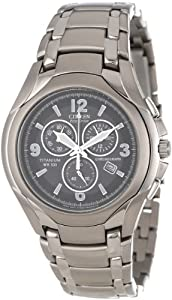


Title:          Men's Black Stainless Steel Quartz Chronograph Date Display Roman Numerals
Description:    None...
Price:          228.99
ID:             B005OB6UPY
Score:          5.480685


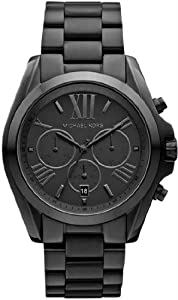


Title:          Peugeot Women's PS4905BS Swiss Ceramic Black Crystal Bezel Watch
Description:    None...
Price:          175.0
ID:             B00753QOAA
Score:          5.4746485


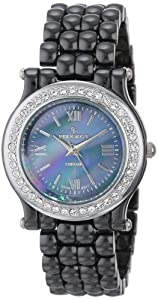

In [100]:
body = {
    "query": {
        "function_score": {
            "query": {
                "multi_match": {
                    "query": "Black",
                    "fields": ["title^2", "description"]
                }
            },
            "boost_mode": "replace",
            "functions": [
                {
                    "elastiknn_nearest_neighbors": {
                        "field": "imVecElastiknn",
                        "similarity": "angular",
                        "model": "exact",
                        "vec": {
                            "values": query_vec
                        }
                    },
                    "weight": 3
                }
            ]
            
        }
    }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

## Combine keyword and nearest neighbors queries using Elastiknn's approximate query

"Black" is a very frequent term in a catalog of clothing, shoes, and jewelry. 
The queries above are matching 10k docs for the term itself, and then evaluating nearest neighbors on those docs.


In [102]:
body = {
    "query": {
        "function_score": {
            "query": {
                "multi_match": {
                    "query": "Black",
                    "fields": ["title^2", "description"]
                }
            },
            "boost_mode": "replace",
            "functions": [
                {
                    "elastiknn_nearest_neighbors": {
                        "field": "imVecElastiknn",
                        "similarity": "angular",
                        "model": "lsh",
                        "candidates": 100,
                        "vec": {
                            "values": query_vec
                        }
                    },
                    "weight": 3
                }
            ]
            
        }
    }
}

res = es.search(index=index, body=body, size=5, _source=source_no_vecs)
display_hits(res)

TransportError: TransportError(500, 'search_phase_execution_exception', 'Index 2147483647 out of bounds for length 1503384')

## Improve Performance by Adding Shards